# Processing the B3DB brain-blood barrier dataset
> 

- toc: true 
- badges: true
- comments: true
- categories: [python, bioinformatics, datasets, SMILES, cheminformatics, datamol, RDKit, molecules]
- image: images/bloodcell.gif

# Gathering data on blood brain barrier permeability

This post is a part of a fullstack machine learning web app project and this notebook contains the data needed to build and train the models. The goal in this post is to clean and preprocess the B3DB dataset and merge it with the blood brain permeability data from MoleculeNet. The merged dataset should contain nearly 10,000 molecules labeled with their ability to pass through the blood brain barrier. The notebook provided in the B3DB repository also contains an interesting PCA plot, which is a good starting place for EDA when the data is merged.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import datamol as dm


%matplotlib inline

# Removing, remapping, and creating features

This dataset has features that can be dropped since they won't contribute to model training. Some features are then calculated from the SMILES data.

In [41]:

# reading in the data
bbb_df = pd.read_csv("data/B3DB_classification.tsv", sep="\t")

# dropping columns
bbb_df = bbb_df.drop(["CID", "logBB", "Inchi", "threshold", "reference", "group", "comments", "NO.", "IUPAC_name", "compound_name"], axis=1)

# mapping given labels to binary
bbb_df['BBB+/BBB-'] = bbb_df['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})

# Feature generation

The function below processes and generates features such as mol objects, selfies, inchi, and inchikeys for each molecule using the datamol library.

In [42]:

# preprocessing function for molecules
def preprocess_smiles(df):
    df["mol"] = [dm.to_mol(x) for x in df['SMILES']] # generating mols from SMILES
    df["mol"] = [dm.fix_mol(x) for x in df['mol']] # Fixing mols

    df = df.dropna() # dropping NA values

    df["mol"] = [dm.sanitize_mol(x, sanifix=True, charge_neutral=False) for x in df['mol']] # sanitize mol objects
    df["mol"] = [dm.standardize_mol(x, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True) for x in df['mol']] # standardize mol objects

    df["standard_smiles"] = [dm.standardize_smiles(x) for x in df['SMILES']] # standardize SMILES
    df["selfies"] = [dm.to_selfies(x) for x in df['mol']] # generate SELFIES
    df["inchi"] = [dm.to_inchi(x) for x in df['mol']] # Generating InChi
    df["inchikey"] = [dm.to_inchikey(x) for x in df['mol']] # Generating InChIKey

    return df

data_clean = preprocess_smiles(bbb_df)

# Making a copy of the dataframe for later
B3DB = data_clean
data_clean.head()

# Saving the data as B3DB; after where its found
data_clean.to_csv('./data/B3DB.csv', index=False)

# Merging the two datasets

The datasets would have ideally added up to 9846 molecules but that doesnt account for duplicates. Since the B3DB consists of data from across 50 studies, I assumed most of the molecules from MoleculeNet would appear in B3DB.

Counting the unique inchikey values confirmed this, leaving  the final dataset with 8091 molecules. This number is lower than the sum of both dataframes but it adds 284 novel compounds to the final dataset.

In [43]:

# Loading the MoleculeNet dataset
MolNet = pd.read_csv("data/MoleculeNet.csv")

# concatenating both dataframes
final_df = pd.concat([MolNet, B3DB])

In [44]:

# Number of molecules before filtering for duplicates
final_df.shape

(9846, 7)

In [45]:

# inchikey values should be unique to each molecule 
final_df.inchikey.value_counts()

FXHJGPDCPMCUKW-UHFFFAOYSA-N    4
UHSKFQJFRQCDBE-UHFFFAOYSA-N    4
CSIVCTHRYRVJCI-UHFFFAOYSA-N    4
UUQMNUMQCIQDMZ-UHFFFAOYSA-N    4
XHMYQXZLVLGNKX-UHFFFAOYSA-N    3
                              ..
XYGVIBXOJOOCFR-BTJKTKAUSA-N    1
NINYZUDVKTUKIA-UHFFFAOYSA-N    1
BVCKFLJARNKCSS-ZJLJEUSSSA-N    1
HOCWPKXKMNXINF-CJIHYQBJSA-N    1
UWHAHBDBSBVMIY-VUXXLBMGSA-N    1
Name: inchikey, Length: 8091, dtype: int64

In [46]:

# Dropping duplicates based on unique inchikey values
final_df = final_df.drop_duplicates(subset='inchikey', keep="first")

# Saving the final dataframe as b3_molecules
final_df.to_csv('./data/b3_molecules.csv', index=False)

# PCA analysis 

PCA does not discard any variables and instead it reduces the number of dimensions by constructing principal components. Principal components describe variation and account for the varied influences of the original features.

Each SMILES string will have a morgan fingerprint generated. These fingerprints are binary 2048 bit arrays which describe molecular structure.

Three plots were made, the first using the MolNet dataset, the B3DB data next, and the combined data last.

In [47]:

# MolNet
# compute ECFP6 Morgan fingerprints with radius 3
fps_molnet = []

for idx, row in MolNet.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    mol = Chem.AddHs(mol)
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol=mol, 
                                               radius=3, 
                                               nBits=2048,
                                               useChirality=True, 
                                               useFeatures=False)
    fps_molnet.append(fp.ToBitString())

# Computing ECFP6 fingerprints for B3DB
fps_B3DB = []

for idx, row in B3DB.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    mol = Chem.AddHs(mol)
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol=mol, 
                                               radius=3, 
                                               nBits=2048,
                                               useChirality=True, 
                                               useFeatures=False)
    fps_B3DB.append(fp.ToBitString())

# Computing ECFP6 fingerprints for B3DB
fps_final = []
for idx, row in final_df.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    mol = Chem.AddHs(mol)
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol=mol, 
                                               radius=3, 
                                               nBits=2048,
                                               useChirality=True, 
                                               useFeatures=False)
    fps_final.append(fp.ToBitString())

# Create a numpy array and use the u1 datatype (uint8 8-bit unsigned integer)
fps_arr_molnet = np.array([np.fromiter(fp, "u1") for fp in fps_molnet])
fps_arr_B3DB = np.array([np.fromiter(fp, "u1") for fp in fps_B3DB])
fps_arr_final = np.array([np.fromiter(fp, "u1") for fp in fps_final])

# PCA on MolNet molecules
molnet_fps = pd.DataFrame(fps_arr_molnet, index=MolNet.index)
molnet_fps = pd.concat([MolNet, molnet_fps], axis=1)

pca_molnet = PCA(n_components=2)
arr_fp_embedded = pca.fit_transform(fps_arr_molnet)
molnet_fps["PC_1"] = arr_fp_embedded[:, 0]
molnet_fps["PC_2"] = arr_fp_embedded[:, 1]

# PCA on B3DB molecules
B3DB_fps = pd.DataFrame(fps_arr_B3DB, index=B3DB.index)
B3DB_fps = pd.concat([B3DB, B3DB_fps], axis=1)

pca_B3DB = PCA(n_components=2)
arr_fp_embedded = pca.fit_transform(fps_arr_B3DB)
B3DB_fps["PC_1"] = arr_fp_embedded[:, 0]
B3DB_fps["PC_2"] = arr_fp_embedded[:, 1]

# PCA on final set of molecules
final_fps = pd.DataFrame(fps_arr_final, index=final_df.index)
final_fps = pd.concat([final_df, final_fps], axis=1)

pca_final = PCA(n_components=2)
arr_fp_embedded = pca.fit_transform(fps_arr_final)
final_fps["PC_1"] = arr_fp_embedded[:, 0]
final_fps["PC_2"] = arr_fp_embedded[:, 1]

# PCA Visualizations

PCA of molecules in the MolecularNet dataset

In [ ]:
fig_molnet = plt.figure(figsize=(15, 10))

plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

sns.scatterplot(data=molnet_fps, x="PC_1", y="PC_2",
                hue="BBB+/BBB-",
                palette=sns.color_palette(["hotpink", "dodgerblue"]),
                linewidth=0.1,
                ).set(title='PCA of molecules in the MolecularNet dataset')
plt.show()

PCA of molecules in the B3DB dataset

In [ ]:
fig_B3DB = plt.figure(figsize=(15, 10))

plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

sns.scatterplot(data=B3DB_fps, x="PC_1", y="PC_2",
                hue="BBB+/BBB-",
                palette=sns.color_palette(["hotpink", "dodgerblue"]),
                linewidth=0.1,
                ).set(title='PCA of molecules in the B3DB dataset')
plt.show()

PCA of molecules in the combined and filtered dataset

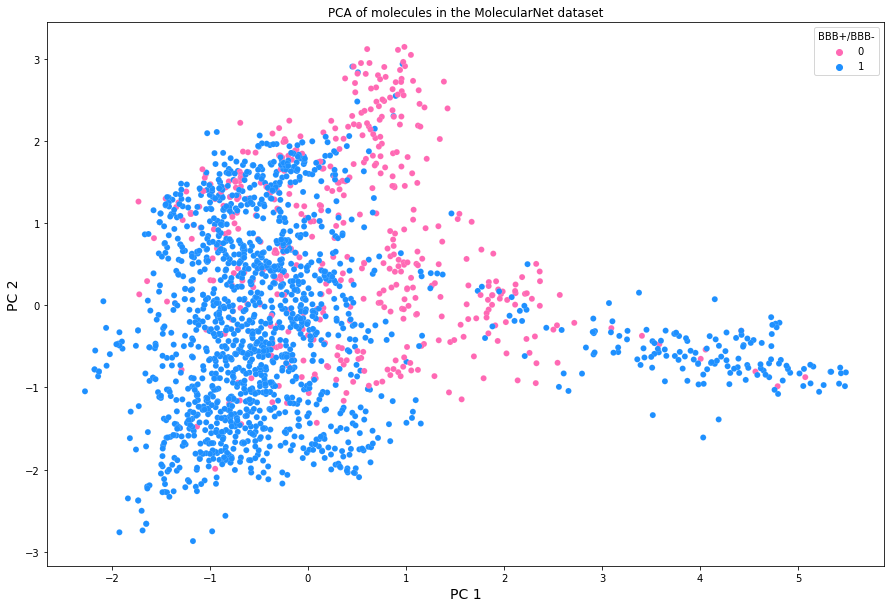

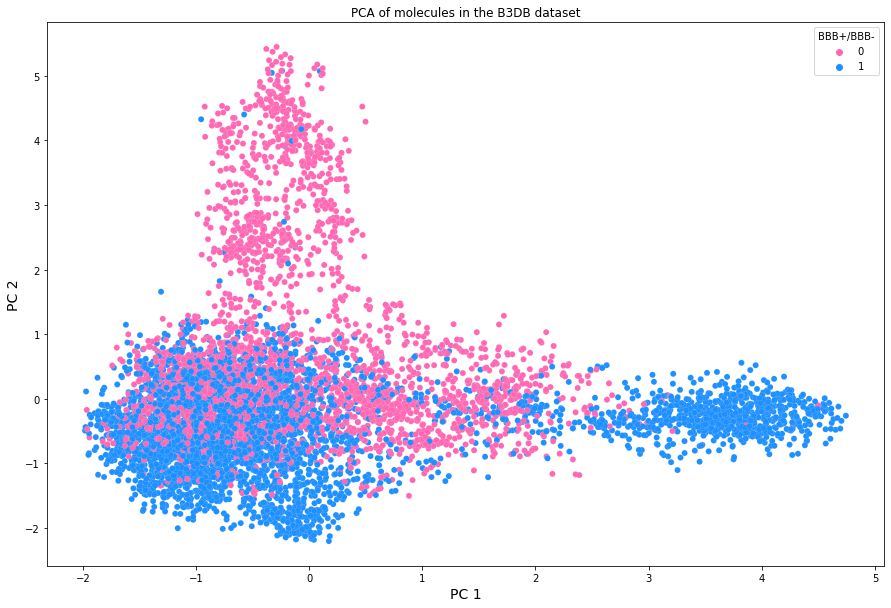

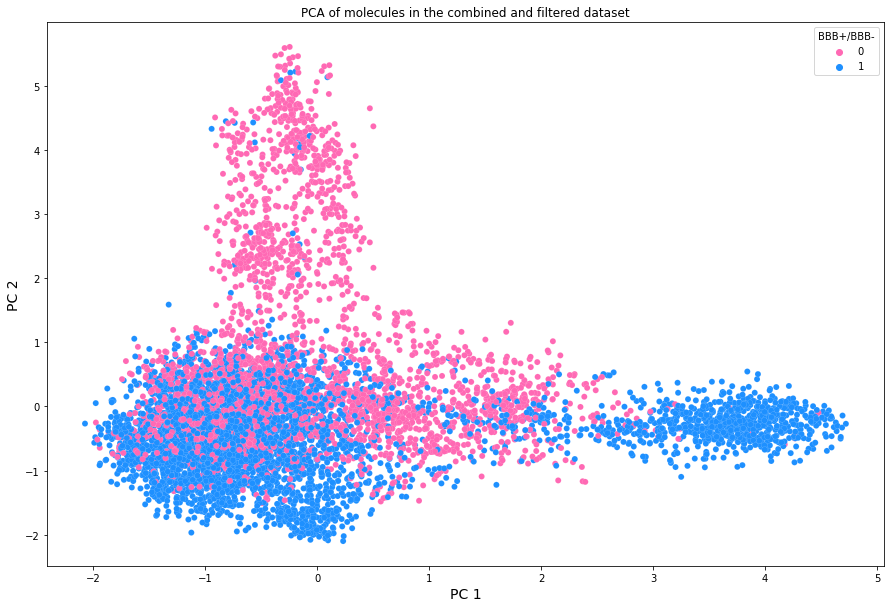

In [48]:
fig_final = plt.figure(figsize=(15, 10))

plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

sns.scatterplot(data=final_fps, x="PC_1", y="PC_2",
                hue="BBB+/BBB-",
                palette=sns.color_palette(["hotpink", "dodgerblue"]),
                linewidth=0.1,
                ).set(title='PCA of molecules in the combined and filtered dataset')
plt.show()